In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal


histogram_bins = np.arange(0, 5, 0.25)

def get_invariant_mean(dimensions):
    return np.zeros(dimensions)

def get_invariant_sigma():
    return 1.5

def get_uniform_sample():
    return np.random.uniform(0, 1)

def prepare_mcmc_samples(dimensions, proposal_sigma):
    invariant_mean = get_invariant_mean(dimensions)
    invariant_sigma = get_invariant_sigma()
    invariant_mvn = get_mvn(dimensions, invariant_mean, invariant_sigma)
    proposal_cov = proposal_sigma * np.array(np.identity(dimensions))

    # set initial proposal - all dimensions = 1
    current_proposal = np.empty(dimensions)
    current_proposal.fill(1)

    samples = [current_proposal]
    for _ in range(300000):
        proposal = np.random.multivariate_normal(current_proposal, proposal_cov)
        u = get_uniform_sample()
        alpha = min(1, invariant_mvn.pdf(proposal) / invariant_mvn.pdf(current_proposal))
        if u < alpha:
            samples.append(proposal)
            current_proposal = proposal
    return samples
    
def plot_histograms_by_distance(dimensions, samples):
    # plot normalized histogram of amount of successful samples by distance from the invariant mean
    invariant_mean = get_invariant_mean(dimensions)
    distances = [np.linalg.norm(x - invariant_mean) for x in samples]
    plt.hist(distances, bins=histogram_bins, density=True, label='MCMC Sampling')

    # invariant normal distribution by distance
    plot_normal_distribution_by_distance(dimensions, get_invariant_mean(dimensions), get_invariant_sigma())
    plt.xlabel('Distance from mean')
    plt.ylabel('Probability')
    plt.title(f'Probability by distance from mean\nNumber of dimensions: {dimensions}')
    plt.legend()
    plt.show()
    

def get_mvn(dimensions, mean, sigma):
    cov = (sigma ** 2) * np.array(np.identity(dimensions))
    mvn = multivariate_normal(mean, cov)
    return mvn


def plot_normal_distribution_by_distance(dimensions, mean, sigma):
    cov = (sigma ** 2) * np.array(np.identity(dimensions))
    distances = []
    for _ in range(100000):
        x = np.random.multivariate_normal(mean, cov)
        distance = np.linalg.norm(x - mean)
        distances.append(distance)
    plt.hist(distances, bins=histogram_bins, density=True, histtype='step', label='Normal distribution')



In [5]:
# In our experiment the invariant distribution is symmetrical. 
# Therefore we can measure the fraction of results by distance from mean. It should be similar 
# to the probablility by distance of our invariant normal distribution.
# We will do it for dimensions from 1 to 5

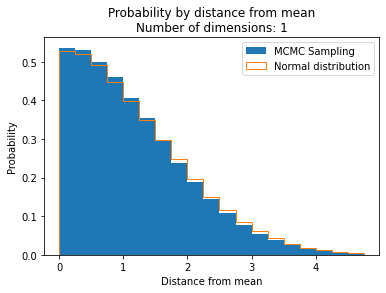

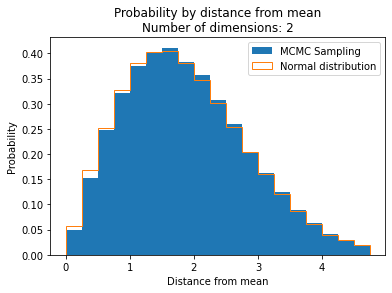

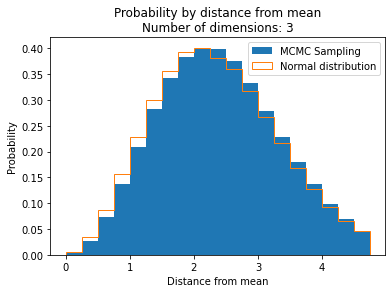

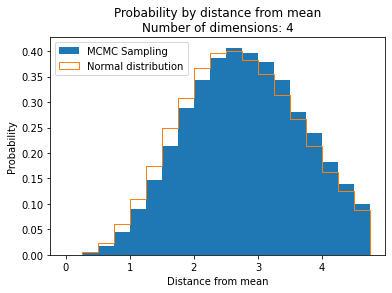

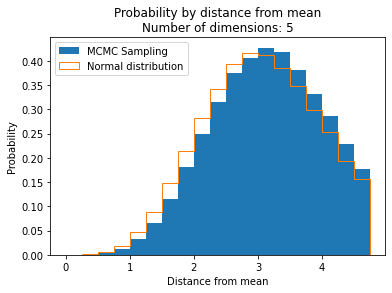

In [11]:
for dimensions in range(1,6):
    samples = prepare_mcmc_samples(dimensions, 2)
    plot_histograms_by_distance(dimensions, samples)


In [ ]:
# Now let's see how the number of accepted samples depends on dimension. 

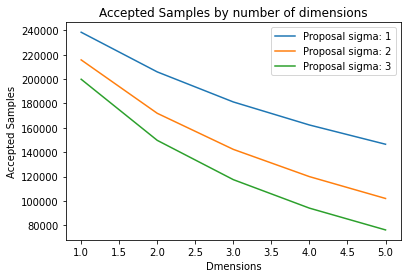

In [21]:
sigmas = [1,2,3]
for sigma in sigmas:
    x_vals = []
    y_vals = []
    for dimensions in range(1,6):
        samples = prepare_mcmc_samples(dimensions, sigma)
        x_vals.append(dimensions)
        y_vals.append(len(samples))
    plt.plot(x_vals, y_vals, label=f'Proposal sigma: {sigma}')   
plt.xlabel('Dimensions')
plt.ylabel('Accepted Samples')    
plt.title('Accepted Samples by number of dimensions')
plt.legend()
plt.show()

In [ ]:
# Now let's see how the number of accepted samples depends on sigma of the propsal distribution. 

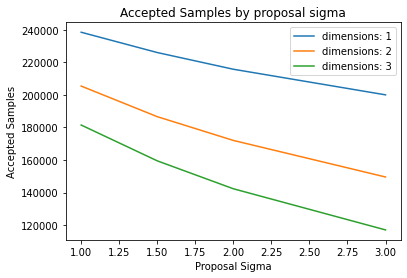

In [23]:
sigmas = [1,1.5,2,3]
for dimensions in range(1,4):
    x_vals = []
    y_vals = []
    for sigma in sigmas:
        samples = prepare_mcmc_samples(dimensions, sigma)
        x_vals.append(sigma)
        y_vals.append(len(samples))
    plt.plot(x_vals, y_vals, label=f'dimensions: {dimensions}')   
plt.xlabel('Proposal Sigma')
plt.ylabel('Accepted Samples')    
plt.title('Accepted Samples by sigma of the proposal distribution')
plt.legend()
plt.show()